# Когортный анализ
Ссылка на данные:
* https://www.kaggle.com/datasets/bilalozgur/online-retail-rfm-and-cohort-analysis-customer-seg?resource=download

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use("dark_background")
plt.style.use('seaborn-v0_8-white')
pd.options.display.max_rows = 50
pd.options.display.max_columns = 120
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Читаем данные
df = pd.read_csv('customer.csv', parse_dates = ['InvoiceDate'])
df.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
0,2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,77,female,26300.794657,United Kingdom
1,2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,77,female,26300.794657,United Kingdom
2,2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,77,female,26300.794657,United Kingdom
3,2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,77,female,26300.794657,United Kingdom
4,2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,77,female,26300.794657,United Kingdom


In [3]:
# Посмотрим на размер и типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceDate  541909 non-null  datetime64[ns]
 1   InvoiceNo    541909 non-null  object        
 2   StockCode    541909 non-null  object        
 3   Description  540455 non-null  object        
 4   Quantity     541909 non-null  int64         
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Age          541909 non-null  int64         
 8   Gender       541909 non-null  object        
 9   Income       541909 non-null  float64       
 10  Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 45.5+ MB


In [4]:
# Посмотрим есть ли пропуски
df.isnull().sum()

InvoiceDate         0
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Age                 0
Gender              0
Income              0
Country             0
dtype: int64

#### Есть пропуски в столбце CustomerID, удалим отсутствующие записи, так как без идентификатора пользователя не удастся его определить в какую-либо когорту.

In [5]:
df_work = df.dropna(subset = ['CustomerID'])

In [6]:
# Выведем общее кол-во пропусков
df_work.isnull().sum().sum()

0

In [7]:
# Проверим на дубликаты
df_work.duplicated().sum()

5225

#### Дубликаты есть, удалим их

In [8]:
df_work = df_work.drop_duplicates()

In [9]:
# Выведем общее кол-во дубликатов
df_work.duplicated().sum()

0

In [10]:
# Для удобства приведем значения в столбце CustomerID к целочисленному виду
df_work['CustomerID'] = df_work['CustomerID'].astype(int)

In [11]:
df_work.describe()

,Quantity,UnitPrice,CustomerID,Age,Income
count,401604.000000,401604.000000,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818,38.169640,33461.855399
std,250.283037,69.764035,1714.006089,13.477881,6452.510147
min,-80995.000000,0.000000,12346.000000,15.000000,18662.725643
25%,2.000000,1.250000,13939.000000,28.000000,32029.371629
50%,5.000000,1.950000,15145.000000,36.000000,32989.061562
75%,12.000000,3.750000,16784.000000,45.000000,35186.809490
max,80995.000000,38970.000000,18287.000000,100.000000,45925.206366


#### Здесь видим, что по столбцу Quantity (кол-во) минимум - отрицательное значение, а максимум - то же значение, но положительное, видимо был возврат или отмена заказа. Также в столбце UnitPrice (цена) минимальное значение равно 0, вряд ли мы отдаем бесплатно наш товар, поэтому отфильтруем эти значения.

In [12]:
# Сначала посмотрим на строки с большим кол-ом товаров
df_work.query('Quantity == 80995 or Quantity == -80995')

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
540421,2011-12-09 09:15:00,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,16446,51,female,41446.747462,United Kingdom
540422,2011-12-09 09:27:00,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2.08,16446,51,female,41446.747462,United Kingdom


#### Видим, что заказ сделал один и тот же человек, и с разницей в 7 мин этот заказ был отменен

In [13]:
# Посмотрим на данные с нулевой ценой
df_work.query('UnitPrice == 0')

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
9302,2010-12-05 14:02:00,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,0.0,12647,28,female,33274.191349,Germany
33576,2010-12-16 14:36:00,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,0.0,16560,28,female,32650.674167,United Kingdom
40089,2010-12-21 13:45:00,539722,22423,REGENCY CAKESTAND 3 TIER,10,0.0,14911,42,male,32584.481215,EIRE
47068,2011-01-06 16:41:00,540372,22090,PAPER BUNTING RETROSPOT,24,0.0,13081,45,female,43386.031439,United Kingdom
47070,2011-01-06 16:41:00,540372,22553,PLASTERS IN TIN SKULLS,24,0.0,13081,45,female,43386.031439,United Kingdom
56674,2011-01-13 15:10:00,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,0.0,15107,30,male,32141.207351,United Kingdom
86789,2011-02-10 13:08:00,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,0.0,17560,42,male,33446.990908,United Kingdom
130188,2011-03-23 10:25:00,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,0.0,13239,30,female,32729.604354,United Kingdom
139453,2011-03-30 12:45:00,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,0.0,13113,34,female,33687.081490,United Kingdom
145208,2011-04-04 14:42:00,548871,22162,HEART GARLAND RUSTIC PADDED,2,0.0,14410,54,male,42315.692977,United Kingdom


#### По последней строке видно, что заказано 12540 штук товара по цене 0, делаем вывод, что товары с нулевой ценой это не бонусы/подарки, а скорее ошибки в даных

In [14]:
df_work.query('UnitPrice == 0').shape

(40, 11)

#### Отфильтруем эти 42 строки

In [15]:
df_work.shape

(401604, 11)

In [16]:
df_work = df_work.query('Quantity.abs() != 80995 and UnitPrice != 0')

In [17]:
df_work.shape

(401562, 11)

In [18]:
# Еще раз проверим данные на выбросы
df_work.describe()

,Quantity,UnitPrice,CustomerID,Age,Income
count,401562.000000,401562.000000,401562.000000,401562.000000,401562.000000
mean,12.149972,3.474417,15281.260996,38.169471,33461.487739
std,171.998341,69.767675,1713.981244,13.478227,6452.547706
min,-74215.000000,0.001000,12346.000000,15.000000,18662.725643
25%,2.000000,1.250000,13939.000000,28.000000,32029.371629
50%,5.000000,1.950000,15145.000000,36.000000,32987.877848
75%,12.000000,3.750000,16788.000000,45.000000,35186.809490
max,74215.000000,38970.000000,18287.000000,100.000000,45925.206366


#### Видим, что выбросы в столце Quantity еще остались

In [19]:
# Попробуем посмотреть на заказы, кол-во товаров в которых меньше -1000
df_work.query('Quantity < -1000')

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
4287,2010-12-02 14:23:00,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,0.03,15838,37,female,32954.602474,United Kingdom
61624,2011-01-18 10:17:00,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1.04,12346,37,female,33199.291996,United Kingdom
160142,2011-04-18 13:08:00,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2.55,15749,40,female,34027.182265,United Kingdom
160143,2011-04-18 13:08:00,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2.55,15749,40,female,34027.182265,United Kingdom
160144,2011-04-18 13:08:00,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,1.85,15749,40,female,34027.182265,United Kingdom
160145,2011-04-18 13:08:00,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2.10,15749,40,female,34027.182265,United Kingdom
187609,2011-05-12 15:19:00,C552995,M,Manual,-1350,0.16,18133,25,male,33594.118962,United Kingdom
224419,2011-06-13 11:21:00,C556522,22920,HERB MARKER BASIL,-1515,0.55,16938,43,female,35186.809490,United Kingdom
377448,2011-10-04 17:44:00,C569552,15034,PAPER POCKET TRAVELING FAN,-1200,0.07,14533,34,female,33342.593110,United Kingdom
390544,2011-10-11 11:10:00,C570556,20971,PINK BLUE FELT CRAFT TRINKET BOX,-1296,1.06,16029,43,female,34737.639594,United Kingdom


In [20]:
# Посмотрим на заказ, где кол-во -74215
df_work.query('Quantity.abs() == 74215')

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
61619,2011-01-18 10:01:00,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,12346,37,female,33199.291996,United Kingdom
61624,2011-01-18 10:17:00,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1.04,12346,37,female,33199.291996,United Kingdom


#### Здесь заказ был сделан и отменен через 16 мин тем же пользователем

In [21]:
# Посмотрим на заказ, где кол-во -9360
df_work.query('Quantity.abs() == 9360')

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
4287,2010-12-02 14:23:00,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,0.03,15838,37,female,32954.602474,United Kingdom


In [22]:
df_work.query('CustomerID == 15838 and StockCode == 84347')

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country


#### Здесь просто возврат, но покупки нет

In [23]:
# Посмотрим на заказ, где кол-во -1300
df_work.query('Quantity.abs() == 1300')

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
52771,2011-01-11 12:57:00,540818,47556B,TEA TIME TEA TOWELS,1300,2.55,15749,40,female,34027.182265,United Kingdom
160142,2011-04-18 13:08:00,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2.55,15749,40,female,34027.182265,United Kingdom
160543,2011-04-18 13:20:00,550461,47556B,TEA TIME TEA TOWELS,1300,2.10,15749,40,female,34027.182265,United Kingdom


#### Здесь был сделан заказ и отменен через 3 месяца, а потом снова сделан по меньшей стоимости за ед. товара (таких пользователей несколько)

#### Вывод: не очень понята работа магазина, нужны уточнения у менеджера. Попробуем удалить все заказы с отрицательным кол-вом и заказы с точно таким же кол-вом по модулю от того же пользователя

In [24]:
# Импортируем библиотеку для визуального отображения процесса выполнения метода (т.к. процесс занимет ~4мин)
from tqdm import tqdm
tqdm.pandas()

In [25]:
# Создадим функцию, которая фильтрует отрицательные значения по столбцу Quantity, а также соответствующие
# им положительные значения (избавляемся от всех заказов с отменой)
def remove_cancelled_transactions(df):
    orders_neg = df['Quantity'] < 0
    return df.loc[~(orders_neg | orders_neg.shift(-1))]

In [26]:
# Создадим переменную, в которой будем хранить столбцы для группировки, по которым будем находить дубликаты по модулю
groups = [df_work['StockCode'], df_work['Quantity'].abs(), df_work['UnitPrice'], df_work['CustomerID']]
# Сгруппируем наш датафрейм по ранее выбранным столбцам и применим функцию для удаления дубликатов
df_clean = df_work.groupby(groups, as_index = False, group_keys = False).progress_apply(remove_cancelled_transactions)
df_clean

100%|██████████| 327679/327679 [03:34<00:00, 1529.60it/s]


,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
59184,2011-01-17 11:46:00,541277,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12673,55,male,40149.253420,Germany
58503,2011-01-16 13:04:00,541248,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12748,29,male,31798.776856,United Kingdom
81833,2011-02-04 10:31:00,543179,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12754,38,female,33163.194854,Japan
7598,2010-12-05 11:02:00,537047,10002,INFLATABLE POLITICAL GLOBE,1,0.85,13069,28,male,32081.210646,United Kingdom
160128,2011-04-18 12:56:00,550452,10002,INFLATABLE POLITICAL GLOBE,1,0.85,14525,35,male,33462.465767,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...
213273,2011-06-05 11:53:00,555531,POST,POSTAGE,11,18.00,12678,28,male,32530.650542,France
233300,2011-06-20 13:08:00,557466,POST,POSTAGE,11,18.00,13815,34,male,32843.328945,Germany
134103,2011-03-25 14:53:00,547822,POST,POSTAGE,16,18.00,12668,41,female,33545.868617,Germany
61618,2011-01-18 09:50:00,541430,POST,POSTAGE,18,18.00,12356,37,female,34489.149051,Portugal


In [27]:
# Проверим заказы, сделанные пользователем с CustomerID = 17548, из исходного датафрейма
df_work.query('CustomerID == 17548').sort_values(by = ['InvoiceDate'])

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
235,2010-12-01 10:24:00,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548,17,male,20649.029315,United Kingdom
236,2010-12-01 10:24:00,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548,17,male,20649.029315,United Kingdom
237,2010-12-01 10:24:00,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548,17,male,20649.029315,United Kingdom
238,2010-12-01 10:24:00,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,17548,17,male,20649.029315,United Kingdom
239,2010-12-01 10:24:00,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,3.45,17548,17,male,20649.029315,United Kingdom
240,2010-12-01 10:24:00,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,1.65,17548,17,male,20649.029315,United Kingdom
241,2010-12-01 10:24:00,C536391,22553,PLASTERS IN TIN SKULLS,-24,1.65,17548,17,male,20649.029315,United Kingdom
165028,2011-04-20 12:01:00,550755,22926,IVORY GIANT GARDEN THERMOMETER,4,5.95,17548,17,male,20649.029315,United Kingdom
165027,2011-04-20 12:01:00,550755,22079,RIBBON REEL HEARTS DESIGN,10,1.65,17548,17,male,20649.029315,United Kingdom
165025,2011-04-20 12:01:00,550755,22082,RIBBON REEL STRIPES DESIGN,10,1.65,17548,17,male,20649.029315,United Kingdom


In [28]:
# Проверим заказы, сделанные пользователем с CustomerID = 17548, из очищенного датафрейма
df_clean.query('CustomerID == 17548').sort_values(by = ['InvoiceDate'])

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country


#### Как видим удалились все отрицательные значения, а также соответствующие им положительные, т.е. мы избавились от заказов которые были созданы, а затем отменены, плюс удалили все отрицательные значения (видимо наша таблица не полная или ведется не с самого начала создания магазина)

In [29]:
df_clean.describe()

,Quantity,UnitPrice,CustomerID,Age,Income
count,389931.000000,389931.000000,389931.000000,389931.000000,389931.000000
mean,12.639652,3.074547,15289.564700,38.162829,33461.734705
std,42.264398,21.322366,1713.338656,13.484875,6457.977820
min,1.000000,0.001000,12347.000000,15.000000,18662.725643
25%,2.000000,1.250000,13956.000000,28.000000,32029.371629
50%,6.000000,1.950000,15152.000000,36.000000,32989.061562
75%,12.000000,3.750000,16794.000000,45.000000,35186.809490
max,4800.000000,8142.750000,18287.000000,100.000000,45925.206366


In [30]:
df_clean.query('Quantity == 4800')

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
421632,2011-10-27 12:26:00,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,0.21,12901,52,female,44184.629415,United Kingdom


### Предобработка данных закончена, приступаем к когортному анализу

In [31]:
df_clean.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
59184,2011-01-17 11:46:00,541277,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12673,55,male,40149.253420,Germany
58503,2011-01-16 13:04:00,541248,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12748,29,male,31798.776856,United Kingdom
81833,2011-02-04 10:31:00,543179,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12754,38,female,33163.194854,Japan
7598,2010-12-05 11:02:00,537047,10002,INFLATABLE POLITICAL GLOBE,1,0.85,13069,28,male,32081.210646,United Kingdom
160128,2011-04-18 12:56:00,550452,10002,INFLATABLE POLITICAL GLOBE,1,0.85,14525,35,male,33462.465767,United Kingdom


In [32]:
# Создадим функцию, которая будет округлять дату до месяца (2011-02-17 -> 2011-02-01)
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [33]:
# Создадим столбец с датой заказа, округленной до месяца
df_clean['Invoice_Month'] = df_clean['InvoiceDate'].apply(get_month)

In [34]:
# Создадим столбец с датой первого заказа для каждого клиента, округленной до месяца
df_clean['Cohort_Month'] = df_clean.groupby('CustomerID')['Invoice_Month'].transform(min)

In [35]:
df_clean.tail()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country,Invoice_Month,Cohort_Month
213273,2011-06-05 11:53:00,555531,POST,POSTAGE,11,18.0,12678,28,male,32530.650542,France,2011-06-01,2010-12-01
233300,2011-06-20 13:08:00,557466,POST,POSTAGE,11,18.0,13815,34,male,32843.328945,Germany,2011-06-01,2011-01-01
134103,2011-03-25 14:53:00,547822,POST,POSTAGE,16,18.0,12668,41,female,33545.868617,Germany,2011-03-01,2010-12-01
61618,2011-01-18 09:50:00,541430,POST,POSTAGE,18,18.0,12356,37,female,34489.149051,Portugal,2011-01-01,2011-01-01
22582,2010-12-10 09:48:00,538175,POST,POSTAGE,21,18.0,12471,38,female,33271.134409,Germany,2010-12-01,2010-12-01


In [36]:
# Создадим функцию для извлечения номера дня, месяца и года из столбца с датой
def get_date_elements(df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year

In [37]:
# Создадим переменные, в которых будут храниться данные с месяцами и годами для дат, в которые были совершены заказы
_, invoice_month, invoice_year = get_date_elements(df_clean, 'Invoice_Month')
# Создадим переменные, в которых будут храниться данные с месяцами и годами для дат, когда пользователи делали свой первый заказ
_, cohort_month, cohort_year = get_date_elements(df_clean, 'Cohort_Month')

In [38]:
# Определим индексы с когортами (когорты будут по месяцам, где 0-ой месяц - это месяц, когда клиент купил в первый раз)
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
df_clean['Cohort_Index'] = year_diff*12 + month_diff

In [39]:
df_clean.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country,Invoice_Month,Cohort_Month,Cohort_Index
59184,2011-01-17 11:46:00,541277,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12673,55,male,40149.253420,Germany,2011-01-01,2011-01-01,0
58503,2011-01-16 13:04:00,541248,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12748,29,male,31798.776856,United Kingdom,2011-01-01,2010-12-01,1
81833,2011-02-04 10:31:00,543179,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12754,38,female,33163.194854,Japan,2011-02-01,2011-02-01,0
7598,2010-12-05 11:02:00,537047,10002,INFLATABLE POLITICAL GLOBE,1,0.85,13069,28,male,32081.210646,United Kingdom,2010-12-01,2010-12-01,0
160128,2011-04-18 12:56:00,550452,10002,INFLATABLE POLITICAL GLOBE,1,0.85,14525,35,male,33462.465767,United Kingdom,2011-04-01,2010-12-01,4


In [40]:
# Создадим новую переменную, в которой будем хранить данные о кол-ве уникальных пользователей в каждой когорте
cohort_data = df_clean.groupby(['Cohort_Month', 'Cohort_Index'])['CustomerID'].nunique().reset_index()
cohort_data

,Cohort_Month,Cohort_Index,CustomerID
0,2010-12-01,0,884
1,2010-12-01,1,324
2,2010-12-01,2,286
3,2010-12-01,3,338
4,2010-12-01,4,318
...,...,...,...
86,2011-10-01,1,86
87,2011-10-01,2,41
88,2011-11-01,0,322
89,2011-11-01,1,35


In [41]:
# Создадим сводную таблицу по когортам на основе таблицы cohort_data
cohort_table = cohort_data.pivot(index = 'Cohort_Month', columns = 'Cohort_Index', values = 'CustomerID')
cohort_table

Cohort_Index,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort_Month,,,,,,,,,,,,,
2010-12-01,884.0,324.0,286.0,338.0,318.0,352.0,319.0,307.0,313.0,348.0,331.0,444.0,233.0
2011-01-01,415.0,90.0,111.0,96.0,134.0,119.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,381.0,71.0,71.0,107.0,103.0,94.0,96.0,106.0,93.0,115.0,26.0,NaN,NaN
2011-03-01,451.0,66.0,112.0,88.0,101.0,76.0,120.0,104.0,126.0,40.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,69.0,64.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,283.0,55.0,49.0,49.0,59.0,65.0,75.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,187.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,41.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(100.58333333333333, 0.5, 'COHORT NONTH')

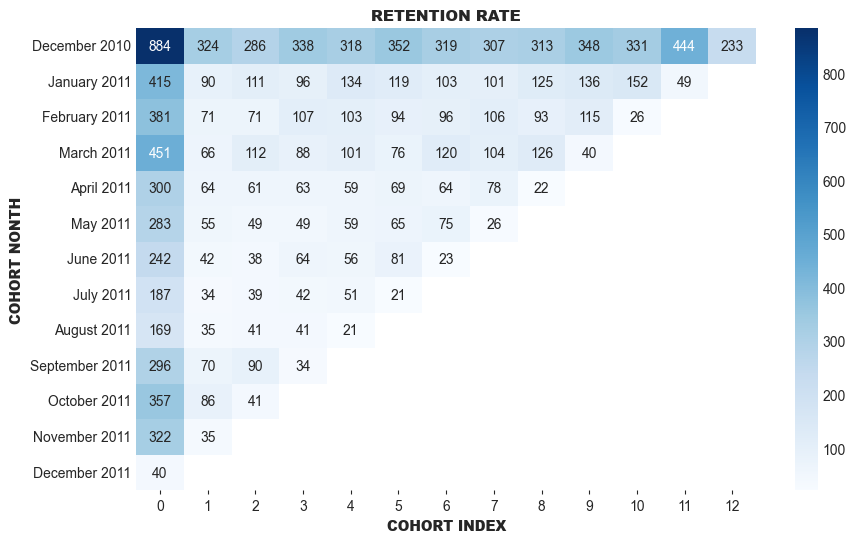

In [42]:
# Визуализируем данные о когортах с количеством клиентов в абсолютных значениях
cohort_table.index = cohort_table.index.strftime('%B %Y')   # приведем столбец с датами в удобный вид (эту строку запускать только 1 раз)
fig, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(cohort_table, annot = True, cmap = 'Blues', fmt = '.0f')
ax.tick_params(axis = 'x', length = 3, direction = 'out')
ax.set_title('RETENTION RATE', fontsize = 11, fontweight = 800)
ax.set_xlabel('COHORT INDEX', fontsize = 10, fontweight = 800)
ax.set_ylabel('COHORT NONTH', fontsize = 10, fontweight = 800)

Text(100.58333333333333, 0.5, 'COHORT NONTH')

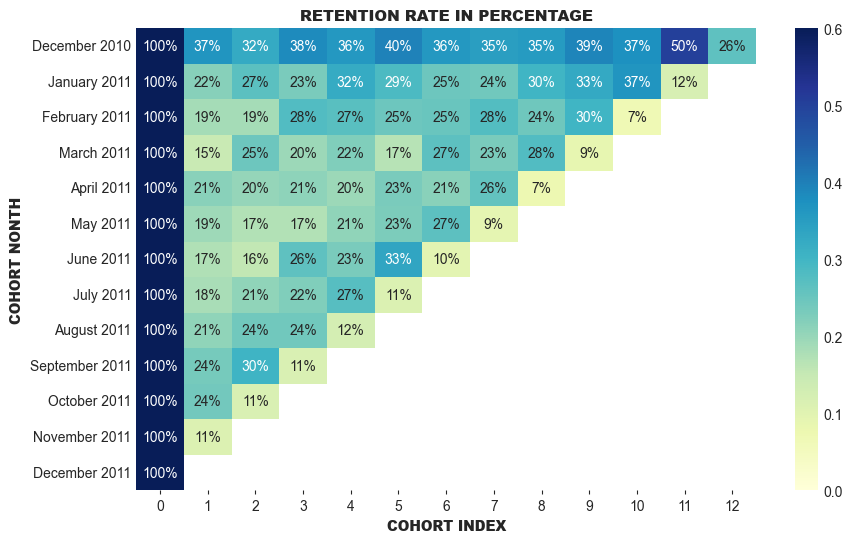

In [43]:
# Визуализируем данные о когортах в процентном отношении
cohort_table_percent = cohort_table.divide(cohort_table.iloc[:,0], axis = 0)
fig, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(cohort_table_percent, annot = True, cmap = 'YlGnBu', fmt = '.0%', vmin = 0.0, vmax = 0.6)
ax.tick_params(axis = 'x', length = 3, direction = 'out')
ax.set_title('RETENTION RATE IN PERCENTAGE', fontsize = 11, fontweight = 800)
ax.set_xlabel('COHORT INDEX', fontsize = 10, fontweight = 800)
ax.set_ylabel('COHORT NONTH', fontsize = 10, fontweight = 800)

# RFM анализ (сегментация клиентов)

In [44]:
# Recency - насколько давно клиент сделал последний заказ
# Frequency - как часто покупал
# Monetary - сколько денег принес

In [45]:
# Будем использовать тот же датасет, уже очищенный, только удалим ненужные столбцы
df_clean.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country,Invoice_Month,Cohort_Month,Cohort_Index
59184,2011-01-17 11:46:00,541277,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12673,55,male,40149.253420,Germany,2011-01-01,2011-01-01,0
58503,2011-01-16 13:04:00,541248,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12748,29,male,31798.776856,United Kingdom,2011-01-01,2010-12-01,1
81833,2011-02-04 10:31:00,543179,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12754,38,female,33163.194854,Japan,2011-02-01,2011-02-01,0
7598,2010-12-05 11:02:00,537047,10002,INFLATABLE POLITICAL GLOBE,1,0.85,13069,28,male,32081.210646,United Kingdom,2010-12-01,2010-12-01,0
160128,2011-04-18 12:56:00,550452,10002,INFLATABLE POLITICAL GLOBE,1,0.85,14525,35,male,33462.465767,United Kingdom,2011-04-01,2010-12-01,4


In [46]:
df_clean = df_clean.drop(columns = ['Invoice_Month', 'Cohort_Month', 'Cohort_Index'])

In [47]:
# Выясним послений день активности клиентов
df_clean['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

### Будем проводить наш анализ на конец октября 2011 года

In [48]:
df = df_clean.query("InvoiceDate <= '2011-10-31'")
df

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Age,Gender,Income,Country
59184,2011-01-17 11:46:00,541277,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12673,55,male,40149.253420,Germany
58503,2011-01-16 13:04:00,541248,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12748,29,male,31798.776856,United Kingdom
81833,2011-02-04 10:31:00,543179,10002,INFLATABLE POLITICAL GLOBE,1,0.85,12754,38,female,33163.194854,Japan
7598,2010-12-05 11:02:00,537047,10002,INFLATABLE POLITICAL GLOBE,1,0.85,13069,28,male,32081.210646,United Kingdom
160128,2011-04-18 12:56:00,550452,10002,INFLATABLE POLITICAL GLOBE,1,0.85,14525,35,male,33462.465767,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...
213273,2011-06-05 11:53:00,555531,POST,POSTAGE,11,18.00,12678,28,male,32530.650542,France
233300,2011-06-20 13:08:00,557466,POST,POSTAGE,11,18.00,13815,34,male,32843.328945,Germany
134103,2011-03-25 14:53:00,547822,POST,POSTAGE,16,18.00,12668,41,female,33545.868617,Germany
61618,2011-01-18 09:50:00,541430,POST,POSTAGE,18,18.00,12356,37,female,34489.149051,Portugal


In [49]:
# Определим день, от которого будем вести все расчеты
today_date = pd.to_datetime('2011-11-01')
today_date

Timestamp('2011-11-01 00:00:00')

In [50]:
# Посчитаем стоимость заказа
df['Order_Amount'] = df['Quantity'] * df['UnitPrice']

In [51]:
# Создадим новую таблицу, агрегированную по CustomerID и с рассчитанными метриками
df_rfm = (df.groupby('CustomerID')
            .agg(Recency = ('InvoiceDate', lambda x: (today_date - x.max()).days),
                 Frequency = ('InvoiceNo', 'count'),
                 Monetary = ('Order_Amount', 'sum')) #т.к у нас нет данных о себестоимости и COGS - будем считать упрощенно, без вычета затрат
            .reset_index())
df_rfm

,CustomerID,Recency,Frequency,Monetary
0,12347,90,124,2790.86
1,12348,36,31,1797.24
2,12350,271,17,334.40
3,12352,33,63,2073.98
4,12353,165,4,89.00
...,...,...,...,...
3951,18280,238,10,180.60
3952,18281,141,7,80.82
3953,18282,87,7,100.21
3954,18283,4,462,1199.82


In [52]:
df_rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,3956.000000,3956.000000,3956.000000,3956.000000
mean,15288.468150,94.615774,77.899646,1760.356960
std,1716.269482,93.597727,174.225301,7578.096423
min,12347.000000,1.000000,1.000000,2.900000
25%,13808.750000,21.000000,15.000000,284.527500
50%,15276.500000,53.000000,37.000000,616.225000
75%,16755.250000,152.000000,85.250000,1484.070000
max,18287.000000,334.000000,5679.000000,242742.590000


### Теперь нужно определиться с тем, на сколько групп будем делить пользователей:
Разделим каждую метрику на 4 группы, то есть группы будут под номерами 1-4, где 1 - это плохой показатель, а 4 - лучший

<AxesSubplot: >

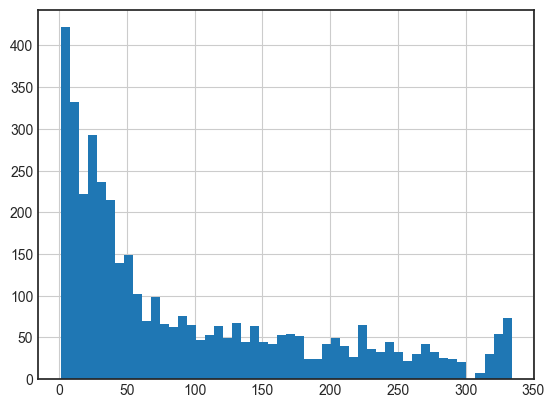

In [79]:
df_rfm['Recency'].hist(bins = 50)

In [54]:
# Создадим функцию, которая будет давать оценки Recency исходя из того, как давно пользователь делал заказ

# Определим ценки следующим образом:
# Если человек сделал последний заказ от 0-15 дней назад, у него оценка 4
# Если человек сделал последний заказ от 16-30 дней назад, у него оценка 3
# Если человек сделал последний заказ от 31-45 дней назад, у него оценка 2
# Если человек сделал последний заказ более 45 дней назад, у него оценка 1

def get_r(x):
    if x in np.arange(0, 16):
        return 4
    if x in np.arange(16, 31):
        return 3
    if x in np.arange(31, 46):
        return 2
    return 1

In [55]:
df_rfm['R'] = df_rfm['Recency'].apply(get_r)

In [56]:
# Создадим столбец R, который будет показывать оценку Recency от 1 до 4, исходя из того, как давно пользователь делал заказ
# df_rfm['R'] = pd.qcut(df_rfm['Recency'], 4, labels = [4, 3, 2, 1])
# df_rfm['R']

In [57]:
# Проверим результаты
df_rfm.groupby('R')['Recency'].agg(['mean', 'count'])

,mean,count
R,,
1,157.508380,2148
2,36.480493,487
3,22.615527,541
4,7.655128,780


<AxesSubplot: >

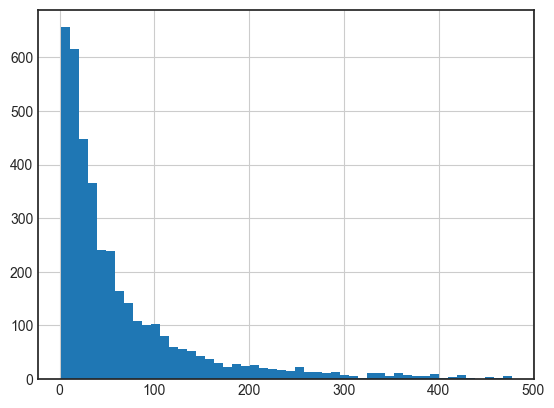

In [80]:
df_rfm.query('Frequency < 500')['Frequency'].hist(bins = 50)

In [59]:
# Создадим функцию, которая будет давать оценки Frequency исходя из кол-ва покупок

# Определим ценки следующим образом:
# Если человек сделал за все время 1-10 заказов у него оценка 1
# Если человек сделал за все время 11-50 заказов у него оценка 2
# Если человек сделал за все время 51-200 заказов у него оценка 3
# Если человек сделал за все время больше 200 заказов у него оценка 4

def get_f(x):
    if x in np.arange(1, 11):
        return 1
    if x in np.arange(11, 51):
        return 2
    if x in np.arange(51, 201):
        return 3
    return 4

In [60]:
# Создадим столбец F, который будет показывать оценку Frequency от 1 до 4, исходя из того, как часто пользователь делал заказ
df_rfm['F'] = df_rfm['Frequency'].apply(get_f)

In [61]:
# Создадим столбец F, который будет показывать оценку Frequency от 1 до 4, исходя из того, как часто пользователь делал заказ
# df_rfm['F'] = pd.qcut(df_rfm['Frequency'].rank(method = 'first'), 4, labels = False) + 1
# df_rfm['F']

In [62]:
# Проверим результаты
df_rfm.groupby('F')['Frequency'].agg(['mean', 'count'])

,mean,count
F,,
1,5.806402,656
2,26.792903,1719
3,97.835605,1247
4,408.095808,334


<AxesSubplot: >

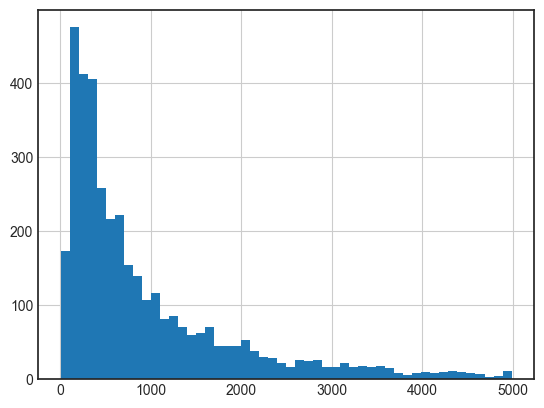

In [81]:
df_rfm.query('Monetary < 5000')['Monetary'].hist(bins = 50)

In [64]:
# Создадим функцию, которая будет давать оценки Monetary исходя из суммарно потраченных денег

# Определим ценки следующим образом:
# Если человек потратил за все время меньше 500 у него оценка 1
# Если человек потратил за все время 501-1000 у него оценка 2
# Если человек потратил за все время 1001-5000 у него оценка 3
# Если человек потратил за все время больше 5001 у него оценка 4

def get_m(x):
    if x < 500:
        return 1
    elif x < 1000:
        return 2
    elif x < 5000:
        return 3
    return 4

In [65]:
# Создадим столбец M, который будет показывать оценку Monetary от 1 до 4, исходя из того, сколько денег потратил пользователь
df_rfm['M'] = df_rfm['Monetary'].apply(get_m)

In [66]:
# Создадим столбец M, который будет показывать оценку Monetary от 1 до 4, исходя из того, сколько денег потратил пользователь
# df_rfm['M'] = pd.qcut(df_rfm['Monetary'], 4, labels = False) + 1
# df_rfm['M']

In [67]:
# Проверим результаты
df_rfm.groupby('M')['Monetary'].agg(['mean', 'count'])

,mean,count
M,,
1,256.213344,1723
2,713.290334,841
3,2097.548417,1187
4,16745.606829,205


In [68]:
# Создадим столбец, отображающий групповую оценку по 3 фаторам
df_rfm['RFM_Group'] = df_rfm[['R', 'F', 'M']].apply(lambda x: '-'.join(x.astype(str)), axis = 1)

In [69]:
# Посчитаем общий результат, сложив все оценки
df_rfm['RFM_Score'] = df_rfm[['R', 'F', 'M']].sum(axis = 1)

In [70]:
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Group,RFM_Score
0,12347,90,124,2790.86,1,3,3,1-3-3,7
1,12348,36,31,1797.24,2,2,3,2-2-3,7
2,12350,271,17,334.40,1,2,1,1-2-1,4
3,12352,33,63,2073.98,2,3,3,2-3-3,8
4,12353,165,4,89.00,1,1,1,1-1-1,3


In [71]:
# Создадим функцию, которая будет относить пользователя к определенному сегменту учитывая его RFM_Score
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif df['RFM_Score'] == 8:
        return 'Champions'
    elif df['RFM_Score'] == 7:
        return 'Loyal'
    elif df['RFM_Score'] == 6:
        return 'Potential'
    elif df['RFM_Score'] == 5:
        return 'Promising'
    elif df['RFM_Score'] == 4:
        return 'Needs Attention'
    else:
        return 'Require Activation'

In [72]:
# Создадим новый столбец с названиями сегментов
df_rfm['RFM_Level'] = df_rfm.apply(rfm_level, axis = 1)

In [111]:
# Отсортируем таблицу по убыванию лояльности клиентов
df_rfm = df_rfm.sort_values(by = 'RFM_Score', ascending = False)
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Group,RFM_Score,RFM_Level
1994,15301,11,240,5015.05,4,4,4,4-4-4,12,Can't Loose Them
3836,18109,8,356,5747.62,4,4,4,4-4-4,12,Can't Loose Them
278,12731,12,250,17306.89,4,4,4,4-4-4,12,Can't Loose Them
91,12472,12,329,6304.03,4,4,4,4-4-4,12,Can't Loose Them
3136,17017,5,205,6532.86,4,4,4,4-4-4,12,Can't Loose Them


In [109]:
# Посмотрим сколько человек в каждом сегменте
df_rfm['RFM_Level'].value_counts()

Needs Attention       786
Can't Loose Them      785
Loyal                 595
Promising             521
Require Activation    443
Potential             441
Champions             385
Name: RFM_Level, dtype: int64

In [108]:
# Посмотрим на сегменты в процентном отношении
(df_rfm['RFM_Level'].value_counts() / len(df_rfm) * 100).round(1)

Needs Attention       19.9
Can't Loose Them      19.8
Loyal                 15.0
Promising             13.2
Require Activation    11.2
Potential             11.1
Champions              9.7
Name: RFM_Level, dtype: float64

Text(0, 0.5, 'COUNT OF CUSTOMERS')

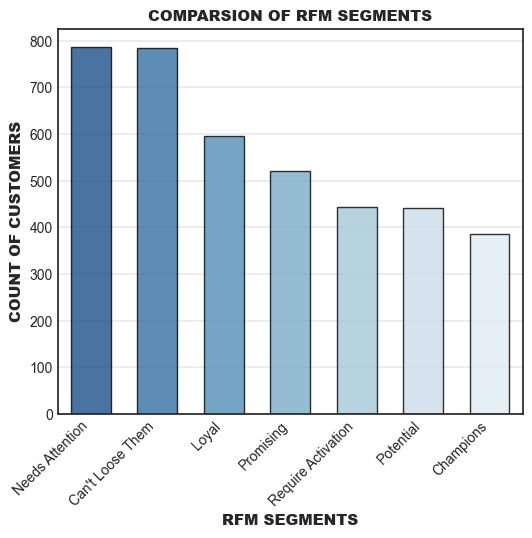

In [75]:
# Отобразим на графике кол-во человек в каждом сегменте
fig, ax = plt.subplots(figsize = (6, 5))
# ax.set(ylim = (0, 21), yticks = np.arange(0, 21))
ax.set_xticklabels(labels = 'x', rotation = 45, ha = 'right')
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.1)
sns.countplot(
    data = df_rfm,
    x = 'RFM_Level',
    order = df_rfm['RFM_Level'].value_counts(ascending = False).index,
    edgecolor = 'black',
    dodge = False,
    alpha = 0.8,
    width = 0.6,
    linewidth = 1,
    palette = 'Blues_r'
    )
ax.set_title('COMPARSION OF RFM SEGMENTS', fontsize = 11, fontweight = 800)
ax.set_xlabel('RFM SEGMENTS', fontsize = 11, fontweight = 800)
ax.set_ylabel('COUNT OF CUSTOMERS', fontsize = 11, fontweight = 800)


In [85]:
# Подготовим данные для следующего графика
rfm_graph = df_rfm.groupby('RFM_Level', as_index = False)['R', 'F', 'M'].mean().round(2)
rfm_graph

,RFM_Level,R,F,M
0,Can't Loose Them,3.55,3.31,3.15
1,Champions,2.66,2.78,2.56
2,Loyal,2.06,2.61,2.33
3,Needs Attention,1.05,1.90,1.05
4,Potential,1.97,2.17,1.86
5,Promising,1.34,2.02,1.64
6,Require Activation,1.00,1.00,1.00


In [86]:
# Изменим представление таблицы
rfm_graph = pd.melt(rfm_graph, id_vars = 'RFM_Level', var_name = 'RFM', value_name = 'Amount')
rfm_graph

,RFM_Level,RFM,Amount
0,Can't Loose Them,R,3.55
1,Champions,R,2.66
2,Loyal,R,2.06
3,Needs Attention,R,1.05
4,Potential,R,1.97
5,Promising,R,1.34
6,Require Activation,R,1.00
7,Can't Loose Them,F,3.31
8,Champions,F,2.78
9,Loyal,F,2.61


Text(0, 0.5, 'AVERAGE RATING')

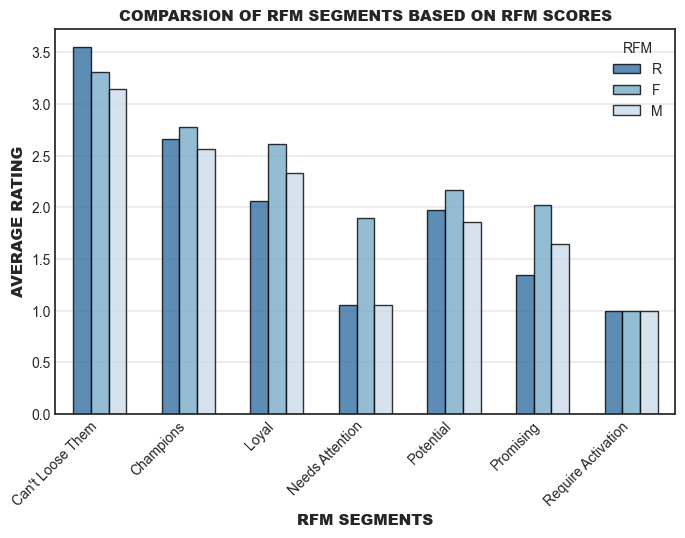

In [87]:
# Сравним на графике сегменты по среднему рейтингу R, F, M
fig, ax = plt.subplots(figsize = (8, 5))
# ax.set(ylim = (0, 21), yticks = np.arange(0, 21))
ax.set_xticklabels(labels = 'x', rotation = 45, ha = 'right')
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.1)
sns.barplot(
    data = rfm_graph,
    x = 'RFM_Level',
    y = 'Amount',
    hue = 'RFM',
    edgecolor = 'black',
    # dodge = False,
    alpha = 0.8,
    width = 0.6,
    linewidth = 1,
    palette = 'Blues_r'
    )
ax.set_title('COMPARSION OF RFM SEGMENTS BASED ON RFM SCORES', fontsize = 11, fontweight = 800)
ax.set_xlabel('RFM SEGMENTS', fontsize = 11, fontweight = 800)
ax.set_ylabel('AVERAGE RATING', fontsize = 11, fontweight = 800)
# plt.legend(loc = 'upper right', title = 'Category')

In [118]:
df_rfm.groupby('RFM_Level').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'}).round(1)

,Recency,Frequency,Monetary
RFM_Level,,,
Can't Loose Them,14.7,221.5,5757.2
Champions,32.3,99.2,1723.4
Loyal,62.1,70.1,1299.8
Needs Attention,170.8,20.4,303.2
Potential,74.0,42.0,884.7
Promising,113.6,33.2,589.0
Require Activation,197.1,5.8,163.4


### Выводы:

Количество человек в каждом сегменте:

- Needs Attention - 786 чел.
- Can't Loose Them - 785 чел.
- Loyal - 595 чел.
- Promising - 521 чел.
- Require Activation - 443 чел.
- Potential - 441 чел.
- Champions - 385 чел.

Сегменты в процентном отношении:

- Needs Attention - 19.9%
- Can't Loose Them - 19.8%
- Loyal - 15.0%
- Promising - 13.2%
- Require Activation - 11.2%
- Potential - 11.1%
- Champions - 9.7%

Резюме по каждому сегменту:
* Needs Attention \
Клиентов этого сегмента у нас больше всего - это люди, которые совершали покупки давно, много, но не на большие суммы. \
Это люди под угрозой оттока, скорее всего они ушли к конкурентам.

    Что можно сделать:

    * отправить скидку, купон на покупку или новость про распродажу
    * сделать персональную подборку товаров
    * обзванивать с предложениями новых услуг

* Can't Loose Them \
Этот сегмент на втором месте по численности. Это новички, которые покупают много и на большие суммы. Это киты. Важно убедить, что мы их ценим, показать им, что они особенные.

    Что можно сделать:

    * VIP-карта
    * премиальное обслуживание
    * подарки ко дню рождения

* Loyal \
Этот сегмент на 3-ем месте по численности. Это лояльные клиенты, которые покупали относительно недавно, делали довольно много покупок по средней цене.

    Что можно сделать:

    * накопительные скидки
    * кешбэк
    * подборки товаров на основе истории заказов

* Promising \
Этот сегмент на 4-ом месте по численности. Это многообещающие клиенты, которые покупали относительно недавно, со средним кол-ом покупок по средней цене. Их нужно стимулировать к новым покупкам.

    Что можно сделать:

    * накопительные скидки
    * подборку сопутствующих товаров

* Require Activation \
Этот сегмент на 4-ом месте по численности. Это потерянныеы клиенты, которые покупали давно, мало и на небольшие суммы. Не стоит тратить на них много времени и внимания.

    Что можно сделать:

    * рассказывать об акциях
    * прислать промокод
    * сделать рассылку из серии «вы 100 миллионов лет не были с нами, а мы улучшили вот то и вот это, дайте нам второй шанс»

* Potential \
Этот сегмент на 5-ом месте по численности. Эти клиенты очень похожи на лояльных, но с чуть меньшим кол-ом покупок и по меньшей цене. Их можно простимулировать к новым покупкам, методы активации те же, что и у лояльных клиентов.

* Champions \
Из этого сегмента людей меньше всего. Это постоянные клиенты, которые покупают много и на большие суммы. Их немного, поэтому можно попробовать перевести их в разряд китов.

    Что можно сделать:

    * VIP-карта
    * премиальное обслуживание
    * подарки ко дню рождения